In [1]:
from osgeo import ogr
from shapely.geometry import MultiLineString
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
from shapely import wkt
import numpy as np
import sys
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pylab as pl
import os

In [2]:
segm_url   = 'https://raw.githubusercontent.com/guillermodangelo/tesis/master/capas/ine_segm_11.gpkg'
censo_url  = 'https://raw.githubusercontent.com/guillermodangelo/tesis/master/tablas/personas_censo_2011.zip'
deptos_url = 'https://raw.githubusercontent.com/guillermodangelo/tesis/master/capas/ine_deptos.gpkg'

In [3]:
deptos = gpd.read_file(deptos_url)

In [4]:
# Datos censales
censo = pd.read_csv(censo_url, compression='zip', header=0, sep=',', quotechar='"')

In [5]:
# carga capa de segmentos censales
seg = gpd.read_file(segm_url)

In [6]:
seg['CODSEG'] = seg['CODSEG'].astype(str)
seg.drop_duplicates('CODSEG', inplace=True)
seg.shape

(4302, 12)

In [7]:
# calcula la población de cada segmento censal
poblacion = censo[['DPTO', 'LOC', 'SECC', 'SEGM','PERPH02']].groupby(by=['DPTO','LOC', 'SECC', 'SEGM']).count()
poblacion.rename(columns={'PERPH02': 'poblacion'}, inplace=True)
                 
poblacion.reset_index(inplace=True)

# genera codloc
poblacion['CODSEG'] = poblacion.DPTO.astype(str) + poblacion.SECC.astype(str).str.zfill(2) + poblacion.SEGM.astype(str).str.zfill(3)

print(poblacion.shape)
poblacion.head()

(4283, 6)


,DPTO,LOC,SECC,SEGM,poblacion,CODSEG
0,1,20,1,1,696,101001
1,1,20,1,2,660,101002
2,1,20,1,3,786,101003
3,1,20,1,104,882,101104
4,1,20,1,105,818,101105


In [8]:
poblacion.drop_duplicates('CODSEG', inplace=True)

In [9]:
pobl_seg = pd.merge(seg, poblacion, on='CODSEG')

**Ecuación del centro medio de población**

$$
\overline{X}_w=\frac{\sum_{i=1}^{n}w_{i}X_{i}}{\sum_{i=1}^{n} w_{i}}
$$


$$
\overline{Y}_w=\frac{\sum_{i=1}^{n}w_{i}Y_{i}}{\sum_{i=1}^{n} w_{i}}
$$

In [23]:
x_mean = []
y_mean = []
    
for n in range (1, 20): # itera sobre departamentos
    df = pobl_seg[pobl_seg.DEPTO== n ].reset_index()

    rango = range(df.shape[0])
    x = [df.loc[i].geometry.centroid.x * df.loc[i].poblacion for i in rango]
    y = [df.loc[i].geometry.centroid.y * df.loc[i].poblacion for i in rango]

    x_mean.append( np.int64( ( sum(x) / df.poblacion.sum() ) )) # completa la formula
    y_mean.append( np.int64( ( sum(y) / df.poblacion.sum() ) ))

In [26]:
mean_center = pd.DataFrame({'DEPTO': np.arange(1,20).tolist(), 'x': x_mean, 'y': y_mean})


mean_center_gdf = gpd.GeoDataFrame(mean_center.DEPTO,
                                   geometry=gpd.points_from_xy(mean_center.x, mean_center.y),
                                   crs= {'init' :'epsg:32721'})

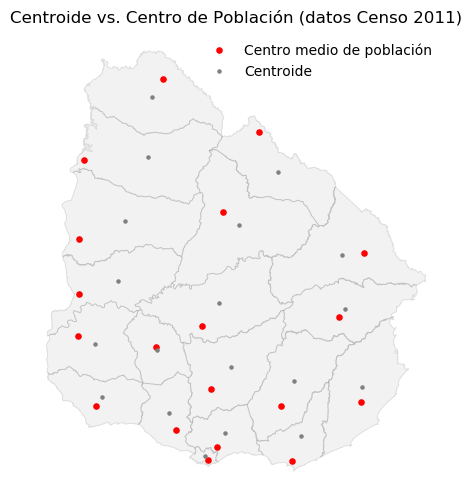

In [36]:
# plot de las capas de departamentos y localidades
plt.style.use('default')

f, ax = pl.subplots(figsize=(8,6))

# deptos
deptos.plot(linewidth = 0.7, edgecolor='black', color = 'grey', alpha=0.1, ax = ax)

# localidades
mean_center_gdf.plot(markersize=14, color = 'red', ax = ax, label='Centro medio de población')
deptos.geometry.centroid.plot(markersize=5, color = 'grey', ax = ax, label='Centroide')

# oculta ejes
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# hide spines
[ax.spines[i].set_visible(False) for i in ['right', 'top', 'left', 'bottom']]

# título
pl.title("Centroide vs. Centro de Población (datos Censo 2011)", size=12)

# referencias
plt.legend(frameon=False)

In [14]:
# exporta geopaquete
mean_center_gdf.to_file("capas/centro_poblacion.gpkg", layer='centro_de_poblacion', driver="GPKG")